# <center> Analyzing football team's stats <center/>

## Imports

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

from matplotlib.patches import Rectangle, PathPatch
from matplotlib.colors import to_rgb
from matplotlib.legend_handler import HandlerTuple

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load datasets
path = "../Data/"
tm_2022 = pd.read_csv("{}team_stats_2021_2022.csv".format(path), sep=';', encoding='latin-1') 
tm_2023 = pd.read_csv("{}team_stats_2022_2023.csv".format(path), sep=';', encoding='latin-1')

In [3]:
# Define functions for data processing and plotting
def label_rk(rank):
    labels = ["Top 5", "Top 10", "Top 15", "Top 20"]
    RkLg = np.arange(6, 22, 5)
    idx = np.where(rank < RkLg)[0][0]
    return labels[idx]

In [4]:
# Process datasets
data = [tm_2022, tm_2023]
for i in range(2):
   data[i]["Top_Team_Scorer_name"] = data[i]["Top Team Scorer"].apply(lambda x: " ".join(x.split(" ")[:-2]))
   data[i]["Top_Team_Scorer_goals"] = data[i]["Top Team Scorer"].apply(lambda x: x.split(" ")[-1]).astype("int64")
   data[i]["Top_Team_Scorer_contribution"] = data[i]["Top_Team_Scorer_goals"]/data[i]["GF"]
   data[i]["LgRk_label"] = data[i]["LgRk"].apply(label_rk)
   data[i]["GD_xGD_diff"] = data[i]["GD"]- data[i]["xGD"]

tm_2022.rename(columns = {"Pts/G":"Pts/MP"}, inplace=True)
del tm_2022["Top Team Scorer"], tm_2023["Top Team Scorer"]

## Bubble Plots

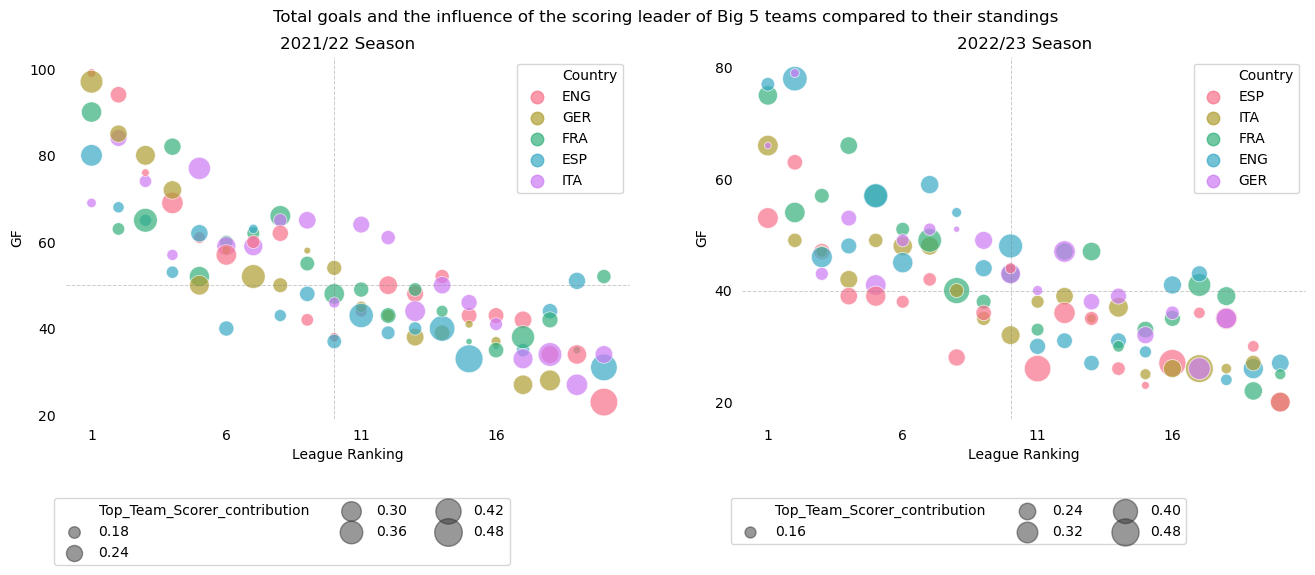

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4.7))
y_ticks = [range(20, 110, 20), range(20, 90, 20)]
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="LgRk", y="GF", size="Top_Team_Scorer_contribution", hue="Country", alpha=0.7,
                    legend=True, palette="husl", sizes=(20, 400), ax=ax[i])
    ax[i].set_xticks(range(1, 21, 5), labels=range(1, 21, 5))
    ax[i].set_yticks(y_ticks[i], labels=y_ticks[i])
    ax[i].axvline(10, color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season".format(title[i]))
    ax[i].set_xlabel("League Ranking")
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend().remove()
    [hand.set_alpha(0.7) for hand in handles[:6]]
    legend = ax[i].legend(handles=handles[:6], labels=labels[:6], markerscale=1.5, loc="best", ncol=1)
    ax[i].add_artist(legend)
    [hand.set_alpha(0.5) for hand in handles[6:]]
    ax[i].legend(handles=handles[6:], labels=labels[6:], bbox_to_anchor=(0.8, -0.2), ncol=3)
    

sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("Total goals and the influence of the scoring leader of Big 5 teams compared to their standings")
plt.show()

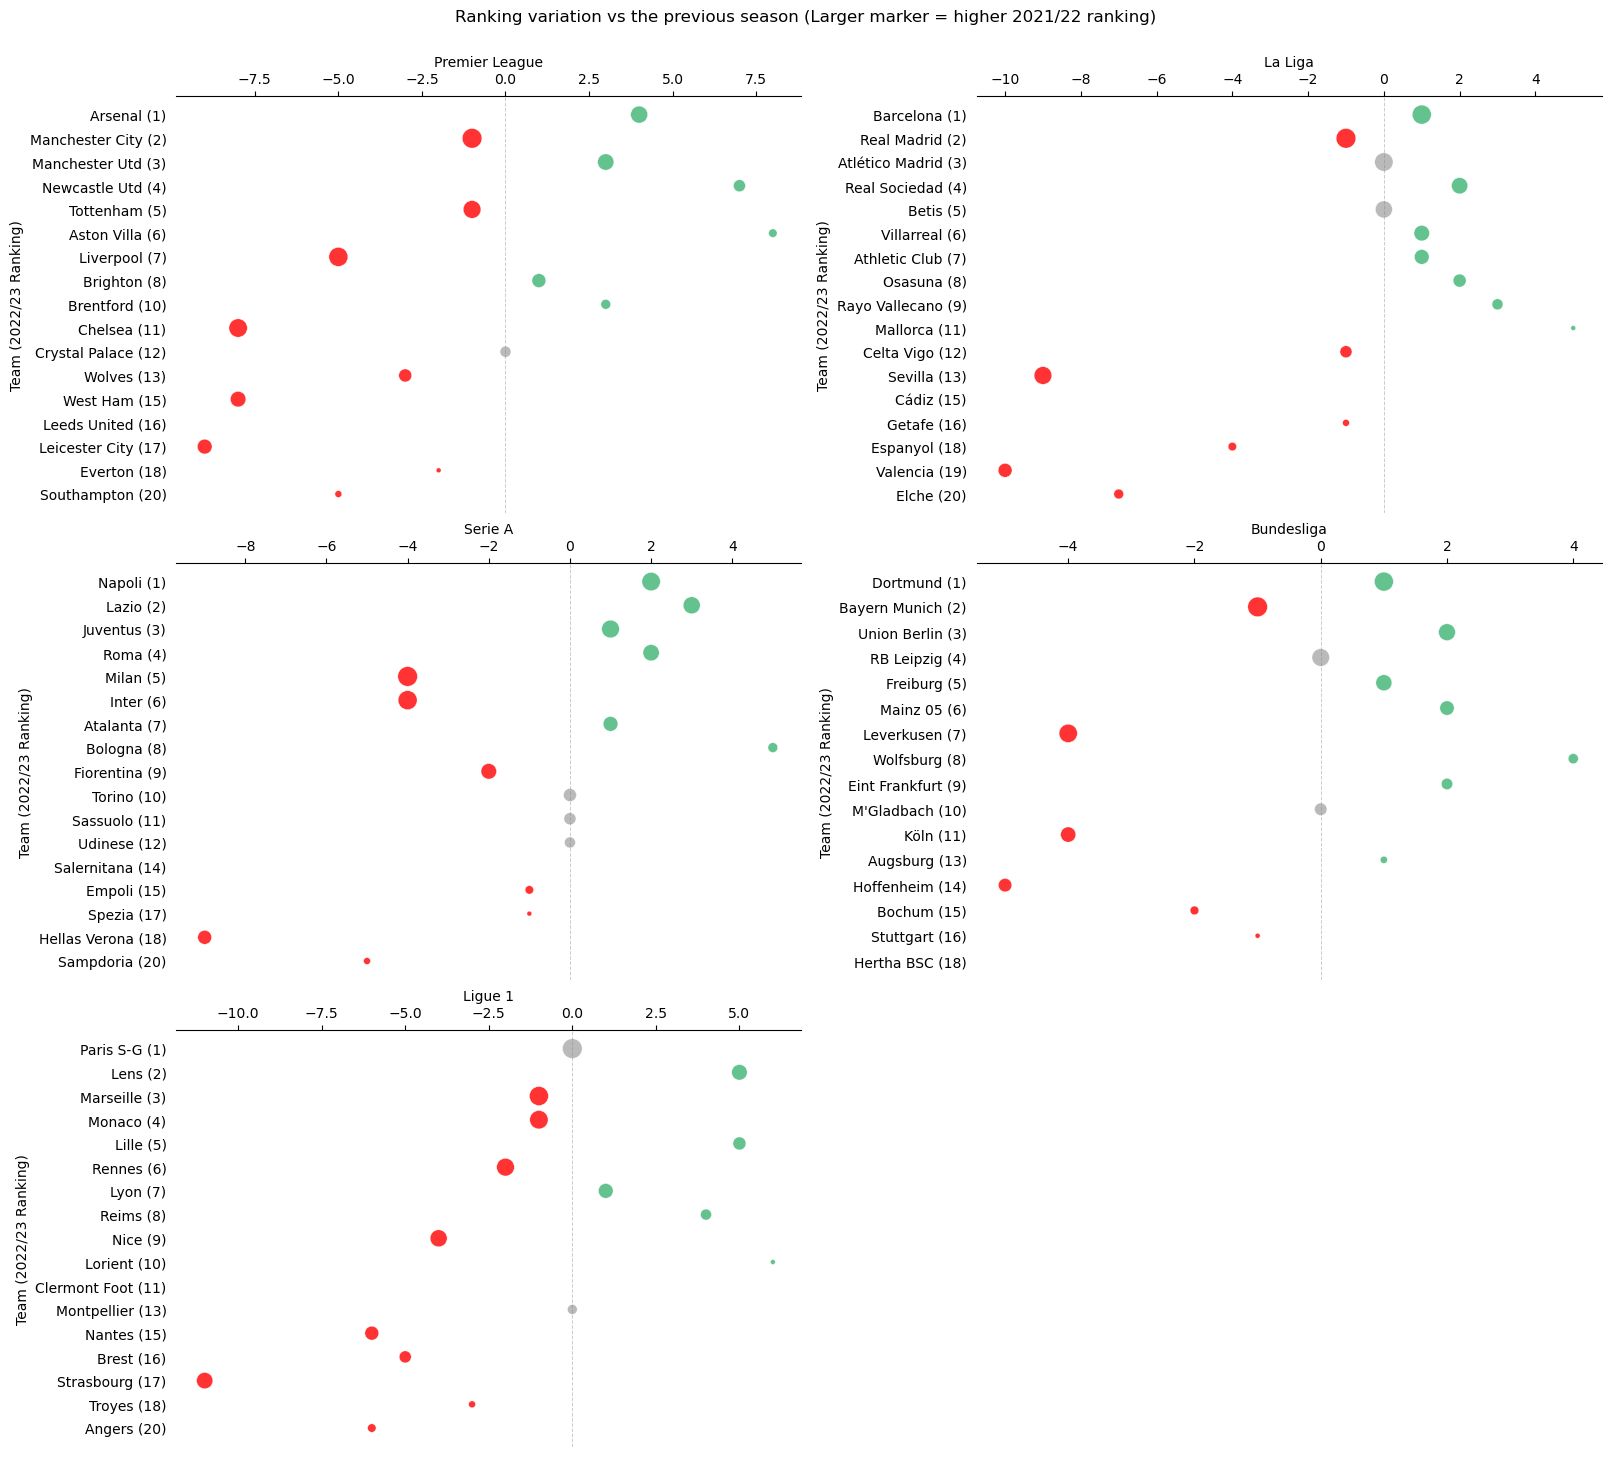

In [6]:
fig, ax = plt.subplots(3, 2, figsize = (16, 14), layout='constrained')
ax[2,1].axis("off")
d_country = {0:['ENG', 'ESP'], 1:['ITA', 'GER'], 2:['FRA']}
d_league = {'ENG': 'Premier League', 'ESP': 'La Liga', 'ITA': 'Serie A', 'GER': 'Bundesliga', 'FRA': 'Ligue 1'}
colors = {-1:"red", 0:"darkgrey", 1:"mediumseagreen"}

for i in range(5):
    country = d_country[i//2][i%2]
    teams_22 = set(tm_2022[tm_2022.Country == country].Squad)
    teams_23 = set(tm_2023[tm_2023.Country == country].Squad)
    rk_2023 = tm_2023[tm_2023.Squad.apply(lambda x: x in (teams_22 & teams_23))].sort_values(by="LgRk").Squad.values
    rk_diff = {squad : tm_2022[tm_2022.Squad==squad].LgRk.iloc[0] - tm_2023[tm_2023.Squad==squad].LgRk.iloc[0] for squad in (teams_22 & teams_23)}
    df_tmp = pd.DataFrame(rk_diff, index = np.arange(1)).T.rename(columns = {0: "Rk_diff"})
    df_tmp["color_enc"] = df_tmp["Rk_diff"].apply(lambda x: 1*(x>0) -1*(x<0))
    df_tmp["Squad"] = df_tmp.index
    df_tmp["Rk_2022_size"] = df_tmp.Squad.apply(lambda x: 500 - 20*tm_2022[tm_2022.Squad==x].LgRk.iloc[0])
    df_tmp["Rk_2023_label"] = df_tmp.Squad.apply(lambda x: x + " ({})".format(str(tm_2023[tm_2023.Squad==x].LgRk.iloc[0])))
    
    sns.scatterplot(df_tmp.loc[rk_2023,:], x ="Rk_diff", y="Rk_2023_label", hue="color_enc", legend=False, \
                    palette=colors, alpha=0.8, size='Rk_2022_size', sizes=(0, 200), marker="o", ax=ax[i//2, i%2])
    ax[i//2, i%2].axvline(0, color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i//2, i%2].set_xlabel("{}".format(d_league[country]))
    ax[i//2, i%2].xaxis.set_label_position('top')
    ax[i//2, i%2].set_ylabel("Team (2022/23 Ranking)") 
    ax[i//2, i%2].tick_params(bottom=False, labelbottom=False, top=True, labeltop=True, left=False)
    ax[i//2, i%2].spines[['right', 'left', 'bottom']].set_visible(False)

plt.suptitle("Ranking variation vs the previous season (Larger marker = higher 2021/22 ranking)", y=1.03)
plt.show()
del teams_22, teams_23, rk_diff, df_tmp

## Scatter Plots

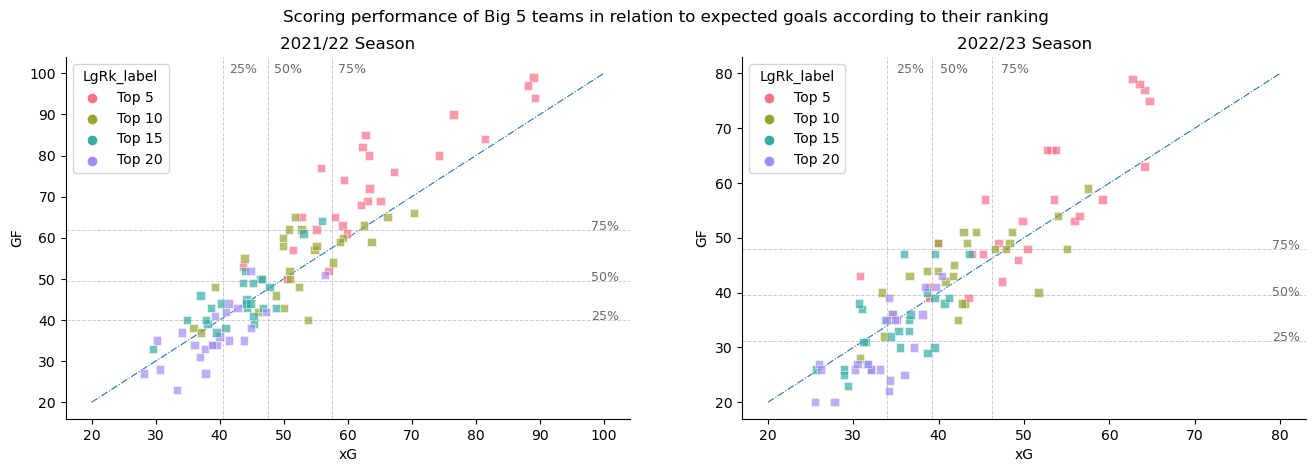

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.7))
data = [tm_2022, tm_2023]
line = [np.linspace(20, 100, 2), np.linspace(20, 80, 2)]
x_text, y_text = [98, 79], [100, 80]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="xG", y="GF", hue="LgRk_label", alpha=0.7, marker="s", legend=True, palette="husl", ax=ax[i], zorder=2)
    ax[i].plot(line[i], line[i], linestyle="-.", linewidth=0.8, zorder=1)
    ax[i].set_title("{} Season".format(title[i]))
    for q in np.arange(0.25, 1, 0.25):
        ax[i].axvline(np.quantile(data[i].xG, q), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
        ax[i].text(np.quantile(data[i].xG, q)+1, y_text[i], f"{int(100*q)}%", size=9, color="dimgrey")
        ax[i].axhline(np.quantile(data[i].GF, q), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
        ax[i].text(x_text[i], np.quantile(data[i].GF, q), f"{int(100*q)}%", size=9, color="dimgrey")
    
sns.despine()
plt.suptitle("Scoring performance of Big 5 teams in relation to expected goals according to their ranking")
plt.show()

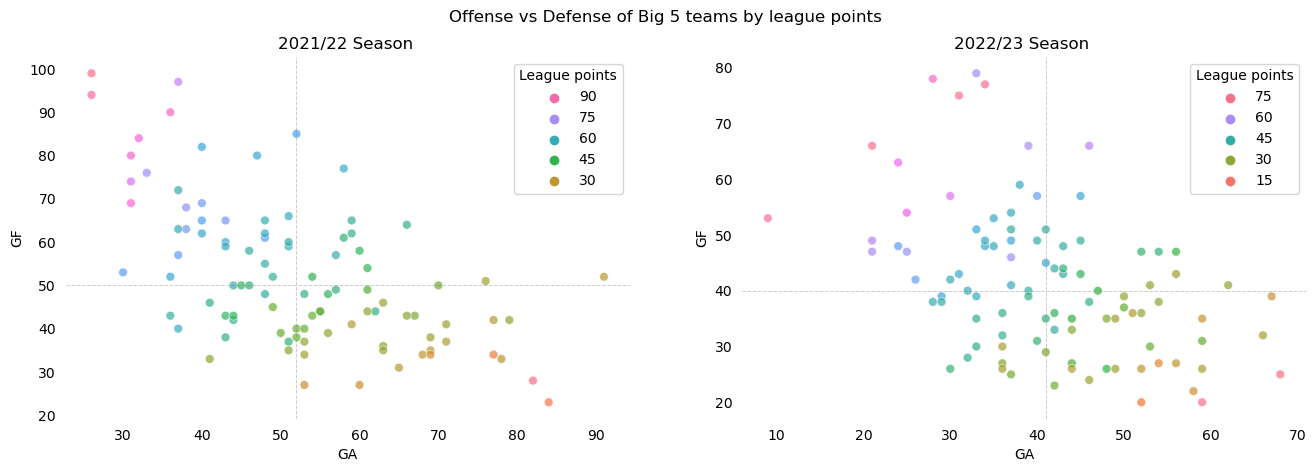

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.7))
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="GA", y="GF", hue="Pts", alpha=0.7, legend=True, palette="husl", s=40, ax=ax[i])
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axvline(np.round(np.median(data[i].GA)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season ".format(title[i]))
    ax[i].legend(title="League points", reverse=True)

sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("Offense vs Defense of Big 5 teams by league points") 
plt.show()

## Pyramid plot and boxplot

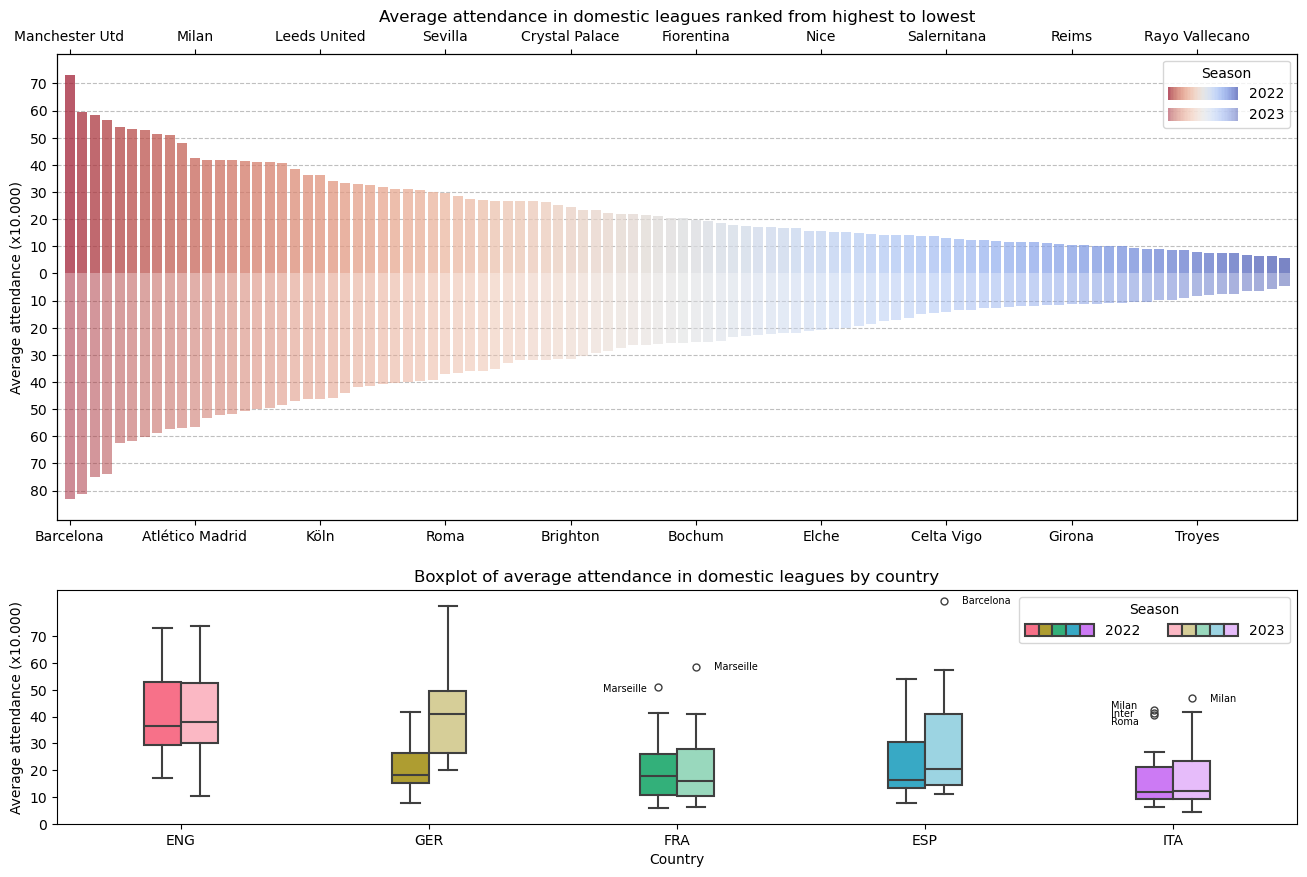

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})
# Upper figure
tm_2023.Attendance = tm_2023.Attendance.apply(lambda x: x*(-1))

sns.barplot(tm_2022.sort_values(by="Attendance", ascending=False), x="Squad", y="Attendance",
            palette="coolwarm_r", alpha=0.75, lw=0, ax=ax[0], zorder=3)

sns.barplot(tm_2023.sort_values(by="Attendance"), x="Squad", y="Attendance", 
            palette="coolwarm_r", alpha=0.52, lw=0, ax=ax[0], zorder=3)

ax[0].set_xticks(range(0, len(tm_2022)+1, 10), labels=tm_2022.sort_values(by="Attendance", ascending=False).Squad.values[::10], rotation = 0)
ax[0].set_yticks(range(-80000, 75000, 10000), labels=list(range(10, 85, 10))[::-1] + list(range(0, 75, 10)))
ax_ = ax[0].twiny()
ax[0].tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)
ax_.tick_params(labelbottom=True, bottom=True, labeltop=False, top=False)
ax_.set_xticks(range(0, len(tm_2023)+1, 10), labels=tm_2023.sort_values(by="Attendance").Squad.values[::10], rotation = 0)
ax[0].set_xlabel("")
ax[0].set_ylabel("Average attendance (x10.000)")
ax[0].set_title("Average attendance in domestic leagues ranked from highest to lowest")
ax[0].set_xlim(-1, len(tm_2022))
ax[0].axhline(0, color="white", linewidth=2)
ax[0].grid(axis='y', linestyle='dashed', alpha=0.8, zorder=0)

ax_.set_xlim(-1, len(tm_2023))
handles = [tuple([p for p in ax[0].patches][98*i:98*(i+1):2]) for i in range(2)]
ax[0].legend(handles=handles, labels = ["2022", "2023"], title="Season", 
              handlelength=5, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})
tm_2023.Attendance = tm_2023.Attendance.apply(lambda x: x*(-1))

tm_2022.insert(0, "Season", 2022)
tm_2023.insert(0, "Season", 2023)

# Lower figure  
df_tmp = pd.concat([tm_2022, tm_2023])
hue_order = ['2022', '2023']
colors = sns.color_palette("husl", 5)

sns.boxplot(df_tmp, x="Country", y="Attendance", hue="Season", width=0.3, saturation=0.5, ax=ax[1], 
            flierprops={"marker": "o", "markerfacecolor":"None"})

# Custom box colors
box_colors = [f + (1 - f) * np.array(to_rgb(c))
              for c in colors for f in np.linspace(0, 0.5, len(hue_order))]

box_patches = [p for p in ax[1].patches if isinstance(p, PathPatch)]

for patch, c in zip(box_patches, box_colors):
    patch.set_facecolor(c)

for collection, color in zip(ax[1].collections, box_colors):
    collection.set_facecolor(color)

# Text annotations for outliers
annotate = {"x": [1.7, 2.15, 3.15, 3.75, 3.75, 3.75, 4.15], 
            "y": [int(x*1000) for x in [49.4, 57.55, 82, 43, 40, 37, 45.7]],
            "s": ["Marseille", "Marseille", "Barcelona", "Milan", "Inter", "Roma", "Milan"]}

for x, y, s in zip(annotate["x"], annotate["y"], annotate["s"]):
    ax[1].text(x=x, y=y, s=s, fontsize=7)

ax[1].set_yticks(range(0, 75000, 10000), labels=range(0, 75, 10))
ax[1].set_ylabel("Average attendance (x10.000)")
ax[1].set_title("Boxplot of average attendance in domestic leagues by country")

handles = [tuple(box_patches[i::len(hue_order)]) for i in range(len(hue_order))]
ax[1].legend(handles=handles, labels=hue_order, title="Season", ncol=2,
          handlelength=5, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

plt.show()

del tm_2022["Season"], tm_2023["Season"]

## t-SNE and PCA projections

In [141]:
scaler = StandardScaler()
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
data = pd.DataFrame(scaler.fit_transform(tm_2022[[col for col in tm_2022.columns if col not in \
                ["Rk", "Country", "Squad", "Goalkeeper", "Top_Team_Scorer_name", "LgRk_label"]]]))

X_train_tsne = tsne.fit_transform(data)
X_train_pca = pca.fit_transform(data)

tm_2022[["tsne_A", "tsne_B"]] = X_train_tsne
tm_2022[["pca_A", "pca_B"]] = X_train_pca

In [11]:
%%time
info = {"eps":[], "min_samples":[], "labels":[]}
for eps in np.arange(0.25, 10.25, 0.5):
    for min_samples in range(3, 16):
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
        info["eps"].append(eps)
        info["min_samples"].append(min_samples)
        info["labels"].append(len(set(dbscan_model.labels_)))
info = pd.DataFrame(info)

CPU times: total: 42.8 s
Wall time: 6.77 s


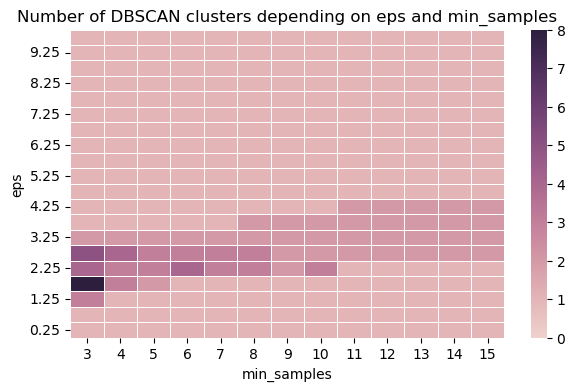

In [130]:
fig, ax = plt.subplots(figsize = (7, 4))
sns.heatmap(info.groupby(["eps", "min_samples"]).max().unstack(level=0).T, cmap=sns.cubehelix_palette(as_cmap=True), vmin=0, vmax=8, 
            linewidth=0.5, linecolor='white', ax=ax)
ax.set_yticks(np.arange(0.5, 20.5)[::2], labels=np.arange(0.25, 10.25, 0.5)[::2])
ax.invert_yaxis()
ax.set_ylabel("eps")
ax.set_title("Number of DBSCAN clusters depending on eps and min_samples")
plt.show()

In [135]:
dbscan_model = DBSCAN(eps=2.75, min_samples=3).fit(data)
kmeans_model = KMeans(n_clusters=4, n_init='auto').fit(data)
pred = kmeans_model.predict(data)
tm_2022["dbscan_labels"] = dbscan_model.labels_
tm_2022["kmeans_labels"] = pred

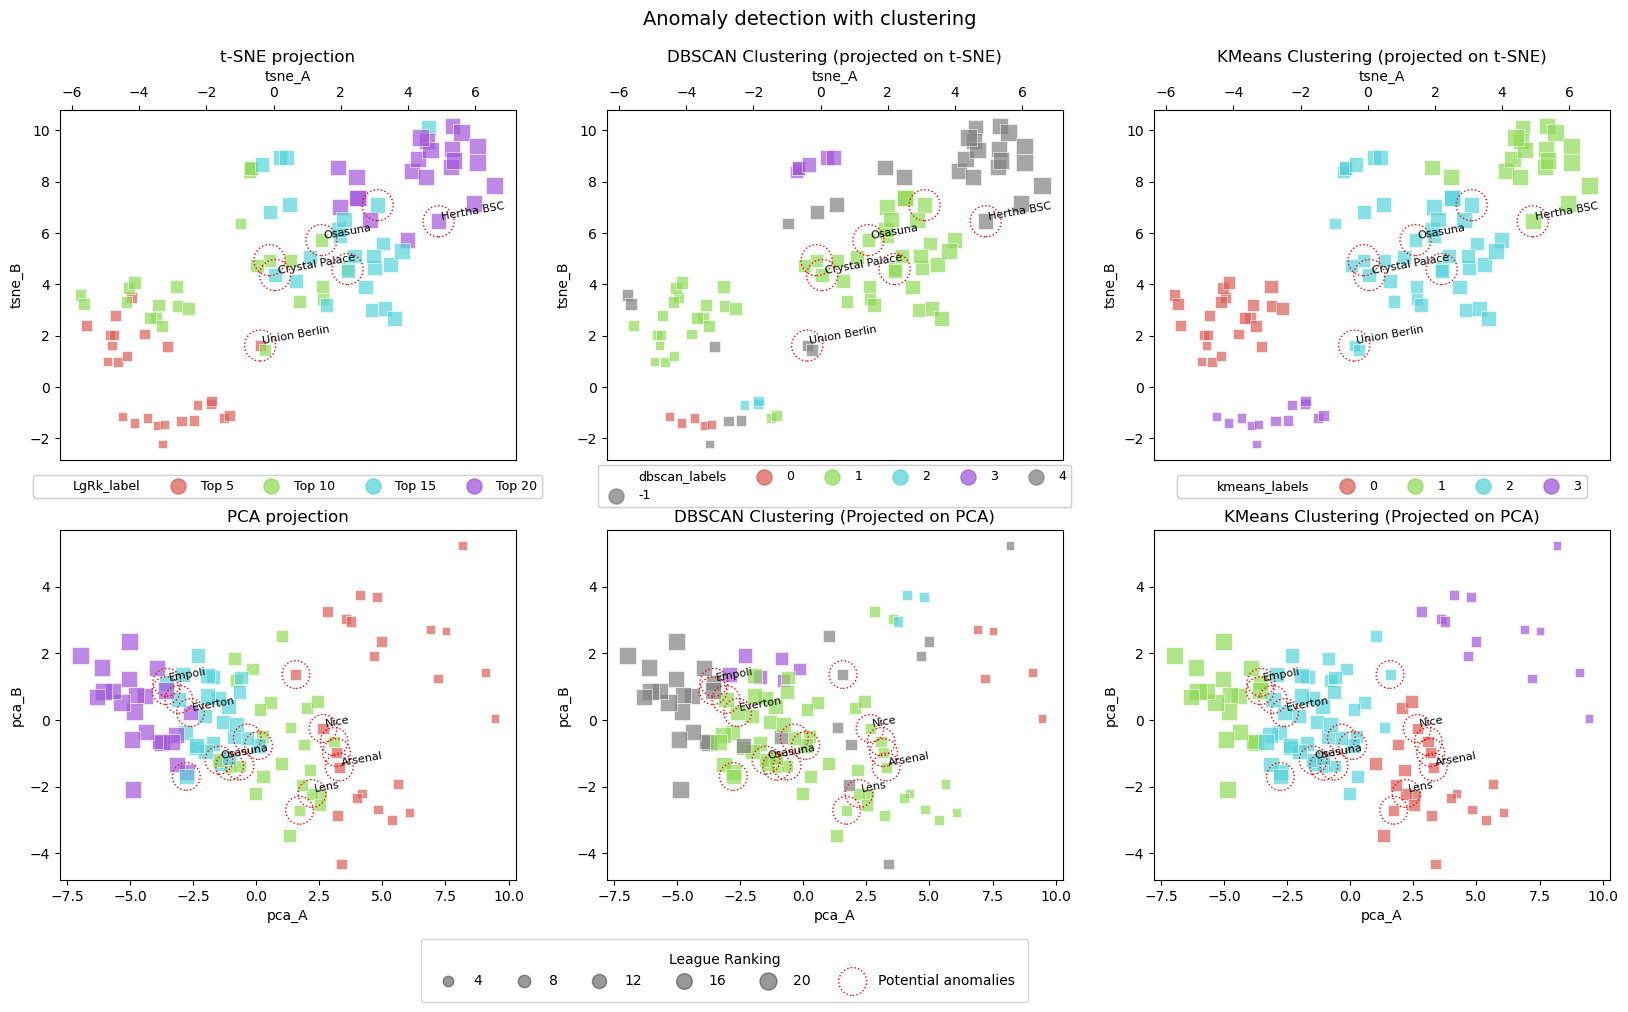

In [142]:
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
# Color palettes
colors = sns.color_palette("hls", 4)
d_color = ["gray"]+[colors[i] for i in range(4)]
palette = ["hls", sns.color_palette(d_color, 5), colors]
# Parameters
anomalies_tsne = ["Union Berlin", "Brighton", "Osasuna", "Wolves", "Crystal Palace", "Southampton", "Hertha BSC"]
anomalies_pca = ["Troyes", "Everton", "Levante", "Sampdoria", "Empoli", "Crystal Palace", "Udinese", "Osasuna", "Wolves", 
                 "Valencia", "Lens", "Real Sociedad", "Union Berlin", "Nice", "Roma", "Betis", "Arsenal"]

X, Y = ["tsne_A", "pca_A"], ["tsne_B", "pca_B"]
h = ["LgRk_label", "dbscan_labels", "kmeans_labels"]
titles = ["t-SNE projection", "DBSCAN Clustering (projected on t-SNE)", "KMeans Clustering (projected on t-SNE)", "PCA projection", 
          "DBSCAN Clustering (Projected on PCA)", "KMeans Clustering (Projected on PCA)"]

for i, ax_ in enumerate(ax.flatten()):
    sns.scatterplot(tm_2022, x=X[i//3], y=Y[i//3], hue=h[i%3], marker="s", size="LgRk", palette=palette[i%3],
                alpha=0.7, sizes=(40, 150), ax=ax_)
    ax_.set_title(titles[i])
    
    if i//3==0:
        # Legend
        ax_.tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)
        ax_.xaxis.set_label_position('top')
        handles, labels = ax_.get_legend_handles_labels()
        ax_.legend().remove()
        [hand.set_alpha(0.7) for hand in handles[:-6]]
        legend = ax_.legend(handles=handles[:-6], labels=labels[:-6], markerscale=1.8, loc='center', 
                                        bbox_to_anchor=(0.5, -0.075), prop={'size': 9}, ncol=6)
        ax_.add_artist(legend)
        [hand.set_alpha(0.5) for hand in handles[-5:]]
        # Annotations
        for j, team in enumerate(anomalies_tsne):
            x, y = tm_2022[tm_2022.Squad == team].tsne_A.values, tm_2022[tm_2022.Squad == team].tsne_B.values
            ax_.scatter(x, y, s=500, facecolors="None", edgecolors="r", linestyle=":", label="Potential anomalies")
            if j%2==0:
                ax_.text(x + 0.05, y + 0.05, team, fontsize=8, rotation=10)
    else:
        # Remove duplicated legend
        ax_.legend().remove()
        # Annotations
        for j, team in enumerate(anomalies_pca):
            x, y = tm_2022[tm_2022.Squad == team].pca_A.values, tm_2022[tm_2022.Squad == team].pca_B.values
            ax_.scatter(x, y, s=400, facecolors="None", edgecolors="r", linestyle=":", label="Potential anomalies")
            if j%3==1:
                ax_.text(x + 0.05, y + 0.05, team, fontsize=8, rotation=10)

anom_h, anom_l = np.array(ax_.get_legend_handles_labels())[:,-1]
ax_.legend(handles=handles[-5:]+[anom_h], labels=labels[-5:]+[anom_l], title="League Ranking", borderpad=1, bbox_to_anchor=(-0.26, -0.15), ncol=6)
plt.suptitle("Anomaly detection with clustering", fontsize=14)
plt.show()